<a href="https://colab.research.google.com/github/ved-phadke/math-m148-final-project/blob/main/embeddings_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings + Multimodal Model

The goal of this notebook is to:
- generate sentence embeddings for each of the transcripts in the dataset
- develop a multimodal classification model to make predictions on  *chills_prob*

# Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import re
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel



# Embeddings

In [ ]:
def create_text_embeddings(
    df,
    stim_name_col="Stimulus name",
    text_col="transcript_clean",
    sentences_col="transcript_sentences",
    model_name="bert-base-uncased",
    device=None,
    embed_dim=768
):
    """
    Creates a two-column DataFrame containing:
        1) The stim name (identifier)
        2) A numpy array representing the text embedding

    If no text is found in a row, returns a zero embedding vector.

    :param df: Input DataFrame with columns for:
                - stim_name_col: Unique identifier for the row
                - text_col: The full text transcript (optional usage)
                - sentences_col: A list (or string) of sentences.
    :param stim_name_col: Name of the column that has the stimulus ID.
    :param text_col: Name of the column that has the cleaned transcript (if needed).
    :param sentences_col: Name of the column that stores a list (or split) of sentences.
    :param model_name: Hugging Face model name to load (default "bert-base-uncased").
    :param device: Torch device (CPU or GPU). If None, auto-detect.
    :param embed_dim: Dimension of the BERT embeddings (768 for bert-base-uncased).

    :return: A DataFrame with columns [stim_name_col, "embedding_vector"].
    """

    # 1. Load model/tokenizer if not provided
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    def embed_text_batch(sentences_list):
        """
        Given a list of sentences, encode them in one batch,
        then average the resulting [CLS] vectors to get a single embedding.
        """
        # Tokenize batch
        encoded = tokenizer(
            sentences_list,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(**encoded)

        # outputs.last_hidden_state shape: [batch_size, seq_len, hidden_dim]
        # We'll take the [CLS] token of each sentence embedding
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: [batch_size, hidden_dim]

        # Average across all sentences
        avg_embedding = torch.mean(cls_embeddings, dim=0)  # shape: [hidden_dim]

        return avg_embedding.cpu().numpy()  # convert to numpy array

    # 2. Prepare a list for our results
    results = []

    for idx, row in df.iterrows():
        stim_name = row[stim_name_col]

        # Attempt to get sentences
        # Make sure 'transcript_sentences' is a list of strings or something you can iterate over
        sentences = row.get(sentences_col, None)

        # If sentences_col doesn't exist or is empty/NaN, we produce zero vector
        if (sentences is None) or (pd.isna(sentences)) or (not sentences) or (sentences[0] == 'nan'):
            # Create a zero embedding of shape (embed_dim,)
            final_embedding = np.zeros(embed_dim, dtype=np.float32)
        else:
            # If sentences is stored as a string like "['sentence1','sentence2']",
            # you might need to convert it back to a list.
            # If it's already a Python list, skip this step.
            if isinstance(sentences, str):
                # Attempt to safely evaluate or parse the string list
                import ast
                try:
                    sentences_list = ast.literal_eval(sentences)
                except:
                    # fallback if the parsing fails
                    sentences_list = [sentences]
            else:
                sentences_list = sentences

            # If there's actually text
            if len(sentences_list) == 0:
                # Nothing to embed
                final_embedding = np.zeros(embed_dim, dtype=np.float32)
            else:
                # Generate average embedding for all sentences in this row
                final_embedding = embed_text_batch(sentences_list)

        # Store the result
        results.append({
            stim_name_col: stim_name,
            "embedding_vector": final_embedding
        })

    # 3. Convert to DataFrame
    embedding_df = pd.DataFrame(results, columns=[stim_name_col, "embedding_vector"])

    return embedding_df


df = pd.read_csv("/content/text_df.csv")
df.drop(['#Chills', 'Chills?', 'Chills Intensity'], axis = 1, inplace = True)
embedding_df = create_text_embeddings(df)
embedding_df.to_csv('embedding_df.csv', index=False)

KeyboardInterrupt: 

In [ ]:
final_text_df = embedding_df.join(
    df[['Stimulus name', 'word_count', 'sentence_count', 'tb_sentiment', 'vader_sentiment', 'pos_nouns', 'pos_adjectives',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
    .set_index('Stimulus name'),
    on='Stimulus name'
)
final_text_df.to_csv('final_text_df.csv', index=False)
pd.to_pickle(final_text_df, 'final_text_df.pkl')

# Multimodal-model

In [ ]:
# Assuming all steps above have been completed, load the final, joined df
df = pd.read_excel("/content/final_df.xlsx")

## Pre-processing

In [ ]:
# Function to fix missing commas in string representations of lists
def fix_list_format(s):
    """
    Fixes formatting issues in string representations of numerical lists, ensuring proper
    comma separation, and converts them to numpy arrays.

    Parameters:
    s (str | any): A string representation of a list or any other data type.

    Returns:
    np.ndarray | NaN | original value: A numpy array if successful, NaN if conversion fails,
                                        or the original value if not a string.
    """
    if isinstance(s, str):
        s = re.sub(r'(?<=\d)\s+(?=[\d-])', ', ', s)  # Insert commas where missing between numbers
        try:
            return np.array(eval(s))  # Convert string list to a numpy array
        except:
            return np.nan  # Return NaN if conversion fails
    return s  # Return original value if not a string


def safe_eval(value):
    """
    Safely converts a string representation of a list into an actual Python list.

    Parameters:
    value (str | list | any): A string representation of a list, a list, or other data type.

    Returns:
    list: If successful, returns the evaluated list; otherwise, returns an empty list.
    """
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Safely evaluate the string as a list
        except (ValueError, SyntaxError):
            return []  # Return an empty list if evaluation fails
    return value if isinstance(value, list) else []  # Return as is if already a list


# Apply fixes to embedding vectors
df["embedding_vector"] = df["embedding_vector"].apply(fix_list_format)

# Create dynamic column names for embedding features
embedding_cols = [f"embedding_{i}" for i in range(len(df["embedding_vector"].dropna().iloc[0]))]

# List of PCA-based features
pca_feature_cols = ["spectrogram_pca", "mfcc_pca", "chroma_pca"]

# Convert string representations of lists to actual lists for PCA features
for col in pca_feature_cols:
    if col in df.columns:
        df[col] = df[col].apply(safe_eval)


In [ ]:
# define columns for expansion of nested features
spec_max_len = max(df["spectrogram_pca"].apply(len), default=0)
mfcc_max_len = max(df["mfcc_pca"].apply(len), default=0)
chroma_max_len = max(df["chroma_pca"].apply(len), default=0)
spec_cols = [f"spec_{i}" for i in range(spec_max_len)]
mfcc_cols = [f"mfcc_{i}" for i in range(mfcc_max_len)]
chroma_cols = [f"chroma_{i}" for i in range(chroma_max_len)]

# Create separate dataframes for expanded features
embedding_df = pd.DataFrame(df["embedding_vector"].dropna().tolist(), columns=embedding_cols)
spec_df = pd.DataFrame(df["spectrogram_pca"].apply(lambda x: x + [0] * (spec_max_len - len(x))).tolist(), columns=spec_cols)
mfcc_df = pd.DataFrame(df["mfcc_pca"].apply(lambda x: x + [0] * (mfcc_max_len - len(x))).tolist(), columns=mfcc_cols)
chroma_df = pd.DataFrame(df["chroma_pca"].apply(lambda x: x + [0] * (chroma_max_len - len(x))).tolist(), columns=chroma_cols)

# Join all separate dataframes together with the main df
df = df.drop(columns=["embedding_vector"]).join(embedding_df)
df = df.drop(columns=["spectrogram_pca"]).join(spec_df)
df = df.drop(columns=["mfcc_pca"]).join(mfcc_df)
df = df.drop(columns=["chroma_pca"]).join(chroma_df)

In [ ]:

# convert dict of list of strings into dict of list of floats
df["color_distribution"] = df["color_distribution"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Extract histograms
color_channels = ["red_histogram", "green_histogram", "blue_histogram"]
for channel in color_channels:
    # Extract the histogram list or default to an empty list
    df[channel] = df["color_distribution"].apply(lambda x: x.get(channel, []) if isinstance(x, dict) else [])

    # Determine the max length of the histograms
    max_len = max(df[channel].apply(len))

    # Expand list values into separate columns, padding with zeros
    channel_cols = [f"{channel}_{i}" for i in range(max_len)]
    channel_df = pd.DataFrame(df[channel].apply(lambda x: x + [0] * (max_len - len(x))).tolist(), columns=channel_cols)

    # Drop original column and merge the expanded ones
    df = df.drop(columns=[channel]).join(channel_df, how="left")

# Drop the original color_distribution column
df = df.drop(columns=["color_distribution"])

In [ ]:
video_feature_cols = ["frame_difference", "average_brightness", "average_contrast"]  # Numeric features
df["has_video"] = df[video_feature_cols].sum(axis=1) != 0  # True if any video feature has data
for col in video_feature_cols:
    df[col] = df[col].fillna(-1)
df["has_video"] = df["has_video"].astype(int) # convert to int

# Model-building

In [ ]:
# Separate features and target variable
X = df.drop(columns=["Stimulus name", "chill_prob"])  # Assuming 'chills_prob' is the response variable
y = (df["chill_prob"] >= 0.5).astype(int)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train XGBoost to identify important features
xgb = XGBClassifier(eval_metric="logloss")
xgb.fit(X_train_pca, y_train)

# Feature selection using XGBoost feature importance
selector = SelectFromModel(xgb, prefit=True)
X_train_selected = selector.transform(X_train_pca)
X_test_selected = selector.transform(X_test_pca)

# Train models
models = {
    "Logistic Regression": LogisticRegression(penalty="l1", solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Hyperparameter tuning for XGBoost
param_dist = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(XGBClassifier( eval_metric="logloss"), param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train_selected, y_train)

# Best model evaluation
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_selected)
print(f"Best XGBoost Model Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))


Model: Logistic Regression
Accuracy: 0.5833
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.62      0.71      0.67         7

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

--------------------------------------------------
Model: Random Forest
Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.71      0.71      0.71         7

    accuracy                           0.67        12
   macro avg       0.66      0.66      0.66        12
weighted avg       0.67      0.67      0.67        12

--------------------------------------------------
Best XGBoost Model Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12



# Feature Importance Visualizations

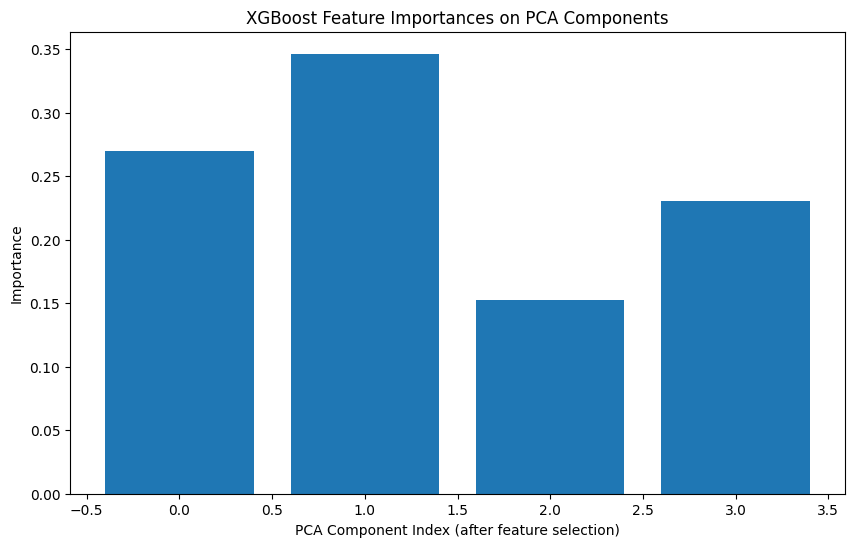

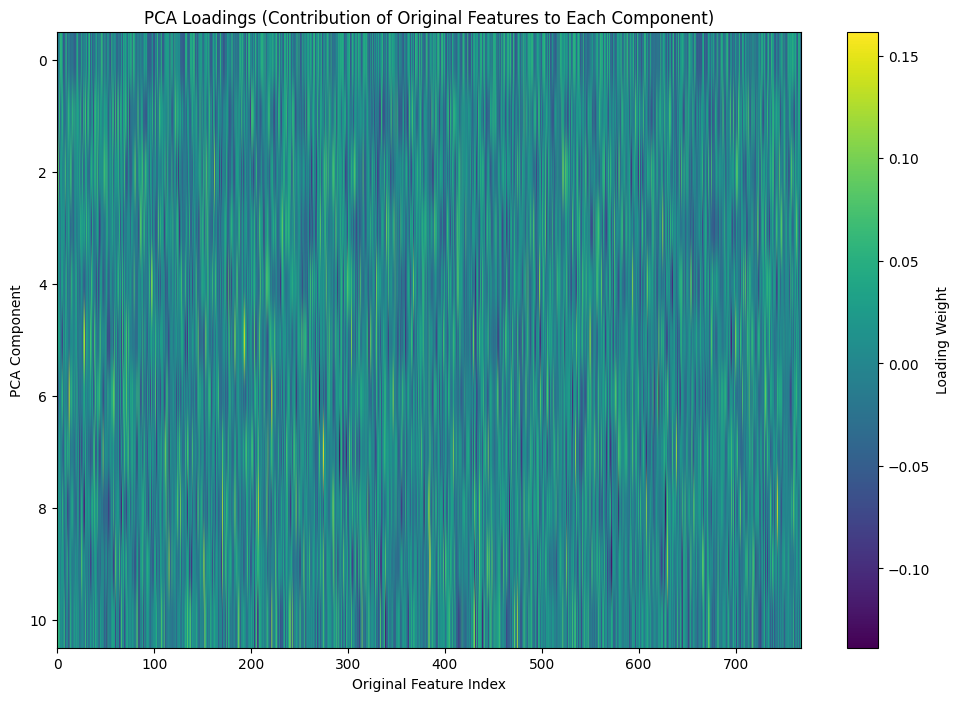

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualize the feature importances from the best XGBoost model (on the selected PCA components)
importances = best_xgb.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel("PCA Component Index (after feature selection)")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances on PCA Components")
plt.show()

# 2. Visualize the PCA loadings for the original features
plt.figure(figsize=(12, 8))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.xlabel("Original Feature Index")
plt.ylabel("PCA Component")
plt.title("PCA Loadings (Contribution of Original Features to Each Component)")
plt.colorbar(label="Loading Weight")
plt.show()


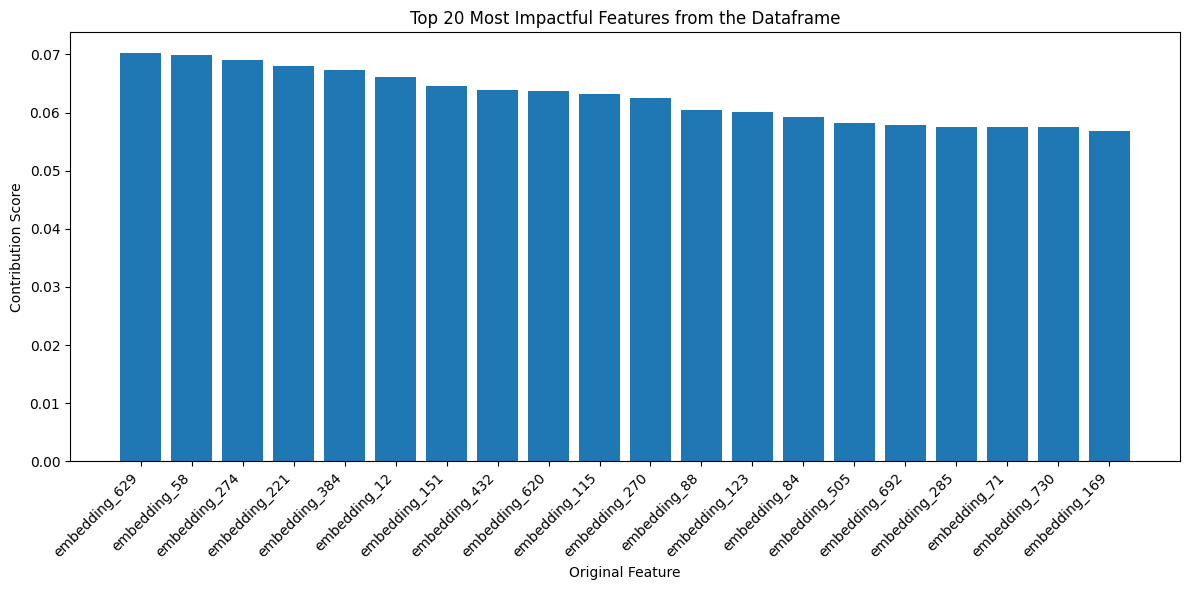

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate contribution of each original feature
# We first determine which PCA components were selected by our feature selector.
selected_mask = selector.get_support()  # Boolean mask for selected PCA components
selected_indices = np.where(selected_mask)[0]

# Initialize an array to store cumulative contributions per original feature.
# pca.components_ shape: (n_components, n_original_features)
n_original_features = pca.components_.shape[1]
feature_contributions = np.zeros(n_original_features)

# For each selected PCA component, accumulate contributions.
# Multiply the model's importance for that component by the absolute value of its loadings.
for i, comp_idx in enumerate(selected_indices):
    weight = best_xgb.feature_importances_[i]
    feature_contributions += weight * np.abs(pca.components_[comp_idx, :])

# Identify the indices of the top 20 features
top20_idx = np.argsort(feature_contributions)[-20:][::-1]
top20_features = X.columns[top20_idx]
top20_contributions = feature_contributions[top20_idx]

# Plot a histogram (bar chart) of the top 20 most impactful features
plt.figure(figsize=(12, 6))
plt.bar(top20_features, top20_contributions)
plt.xlabel("Original Feature")
plt.ylabel("Contribution Score")
plt.title("Top 20 Most Impactful Features from the Dataframe")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Embeddings?
After seeing that the most important features that we have extracted are purely embedding features, how good would a model be that was built on purely embeddings?

In [ ]:
# Separate features and target variable
X = embedding_df
y = (df["chill_prob"] >= 0.5).astype(int)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train XGBoost to identify important features
xgb = XGBClassifier(eval_metric="logloss")
xgb.fit(X_train_pca, y_train)

# Feature selection using XGBoost feature importance
selector = SelectFromModel(xgb, prefit=True)
X_train_selected = selector.transform(X_train_pca)
X_test_selected = selector.transform(X_test_pca)

# Train models
models = {
    "Logistic Regression": LogisticRegression(penalty="l1", solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier( eval_metric="logloss")
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Hyperparameter tuning for XGBoost
param_dist = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(XGBClassifier( eval_metric="logloss"), param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train_selected, y_train)

# Best model evaluation
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_selected)
print(f"Best XGBoost Model Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))


Model: Logistic Regression
Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12

--------------------------------------------------
Model: Random Forest
Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.57      0.57      0.57         7

    accuracy                           0.50        12
   macro avg       0.49      0.49      0.49        12
weighted avg       0.50      0.50      0.50        12

--------------------------------------------------
Model: XGBoost
Accuracy: 0.4167
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Answer: Slightly worse